<a href="https://colab.research.google.com/github/Thomas-D40/deep-learning/blob/main/Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On pars d'un dataset de 1.6M de tweets avec l'objectif de définir s'ils sont positifs ou négatifs

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [65]:
!ls '/gdrive/MyDrive/datasets/sentiment140/'

training.1600000.processed.noemoticon.csv


In [7]:
import pandas as pd

df = pd.read_csv('/gdrive/MyDrive/datasets/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

In [77]:
df.head() # Check des potentiel headers

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df = df.iloc[:, [0,5]] # Pour récupérer toutes les lignes, mais seulement les colonnes 0 et 5

In [12]:
df.columns = ['sentiment', 'tweet']

In [81]:
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [82]:
df.sentiment.value_counts()

,count
sentiment,
0,800000
4,800000


In [9]:
sents_labels = {0: 'negative', 4: 'positive'}

In [10]:
def change_label(label):
  return sents_labels[label]

In [13]:
df['sentiment'].replace(sents_labels)

,sentiment
0,negative
1,negative
2,negative
3,negative
4,negative
...,...
1599995,positive
1599996,positive
1599997,positive
1599998,positive


# Preprocessing with StopWords

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

len(stopwords.words('french'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


157

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

text_cleaning_regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]"

def preprocess(text):
  # Retrait des @, liens et non alpanumériques
  text = re.sub(text_cleaning_regex, ' ', str(text).lower().strip())

  # Retrait des StopWords avec nltk
  stop_words = stopwords.words('english')
  clean_text = [word for word in text.split() if word not in stop_words]

  return " ".join(clean_text).strip()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [115]:
preprocess("  @thomas  Hello, I'm Thomas, i'm wondering what is going on?   ")

'hello thomas wondering going'

# Stemming : Radicalisation des mots

Transformation d'un mot en son radical

Exemple: mangeons, mangez, manges => mange
ou cat, cats => cat

In [16]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def stem_words(text):
  return " ".join([stemmer.stem(word) for word in text.split()])

In [110]:
stemmer.stem("eating")

'eat'

In [17]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

text_cleaning_regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]"

def preprocess(text):
  # Retrait des @, liens et non alpanumériques
  text = re.sub(text_cleaning_regex, ' ', str(text).lower().strip())

  # Retrait des StopWords avec nltk
  stop_words = stopwords.words('english')
  clean_text = [word for word in text.split() if word not in stop_words]

  # Stemming / Radicalisation des mots avec nltk
  stemmer = SnowballStemmer('english')
  clean_text = [stemmer.stem(word) for word in clean_text]

  return " ".join(clean_text).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
preprocess("  @thomas  Hello, I'm Thomas, i'm wondering what is going on?   ")

'hello thoma wonder go'

In [118]:
df.head()

,sentiment,tweet
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


### Application sur le dataset

In [20]:
df['text'] = df['tweet'].apply(preprocess)

# Train test split

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [125]:
len(X_test)

320000

In [127]:
y_test.value_counts()

,count
sentiment,
positive,160506
negative,159494


# Tokenisation + text_to_sequences

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 70000

train_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
train_tokenizer.fit_on_texts(X_train)

test_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
test_tokenizer.fit_on_texts(X_test)


In [157]:
test_words = test_tokenizer.word_index.keys()

train_words = train_tokenizer.word_index.keys()

86825

In [158]:
intersect = set(train_words).intersection(test_words)
len(intersect), len(train_words), len(test_words)

(55875, 204889, 86826)

In [139]:
def length(text):
  return len(text.split(" "))

In [145]:
df['len'] = df['text'].apply(length)

In [147]:
df['len'].describe()

,len
count,1.600000e+06
mean,7.155323e+00
std,4.026880e+00
min,1.000000e+00
25%,4.000000e+00
50%,7.000000e+00
75%,1.000000e+01
max,5.000000e+01


## Distribution de la longueur des phrases

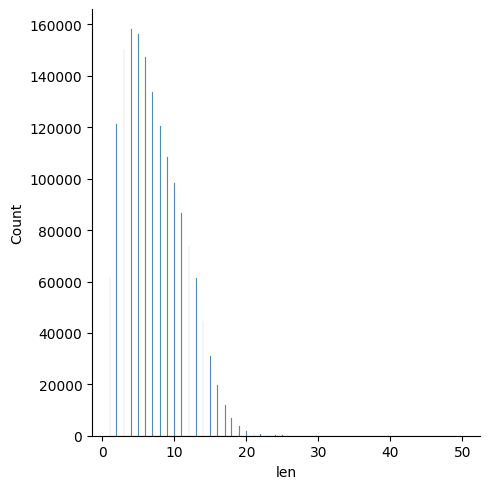

In [160]:
import seaborn as sns
sns.displot(df['len'])

In [ ]:
max_len = 15

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 70000
max_len = 15

train_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
train_tokenizer.fit_on_texts(X_train)
train_padded = pad_sequences(train_tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post', truncating='post')


test_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
test_tokenizer.fit_on_texts(X_test)
test_padded = pad_sequences(test_tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post', truncating='post')

# Label Encoder & Entrainement du modèle

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = le.fit_transform(y_train)
test_labels = le.transform(y_test)

In [174]:
train_labels.shape

(1280000,)

In [26]:
train_labels = train_labels.reshape(-1,1)
test_labels = test_labels.reshape(-1,1)

# Modeling

In [179]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

vocab_size = 70000
max_len = 15
embedding_dimension = int(np.power(vocab_size, 1/4))

train_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
train_tokenizer.fit_on_texts(X_train)
train_padded = pad_sequences(train_tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post', truncating='post')


test_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
test_tokenizer.fit_on_texts(X_test)
test_padded = pad_sequences(test_tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post', truncating='post')

le = LabelEncoder()
train_labels = le.fit_transform(y_train)
test_labels = le.transform(y_test)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension),
    tf.keras.layers.GlobalAveragePooling1D(), # Application d'une moyenne pour trouver l'embedding de la phrase
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
save_best_callback = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

h = model.fit(train_padded, train_labels, epochs=50, validation_data=(test_padded, test_labels),
              batch_size=1024,
              callbacks=[stop_callback, save_best_callback])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.7099 - loss: 0.5743 - val_accuracy: 0.5478 - val_loss: 0.8228
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7782 - loss: 0.4769 - val_accuracy: 0.5462 - val_loss: 0.8498
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7830 - loss: 0.4654 - val_accuracy: 0.5466 - val_loss: 0.8456
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.7867 - loss: 0.4566 - val_accuracy: 0.5453 - val_loss: 0.8717
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7890 - loss: 0.4502 - val_accuracy: 0.5466 - val_loss: 0.8850


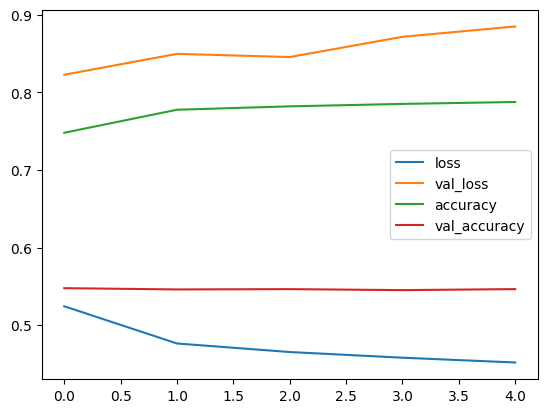

In [180]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label="loss")
plt.plot(h.history['val_loss'], label="val_loss")
plt.plot(h.history['accuracy'], label="accuracy")
plt.plot(h.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="best")

# Recurrent Neural Networks

La limite de l'approche Embedding + LocalAveragePooling:

ex:
"J'étais content, maintenant je suis énervé" => sentiment négatif
"J'étais énervé, maintenant je suis content" => sentiment positif

Avec notre approche actuelle, les deux phrases étant constituées des mêmes mots, nous déduirons un vecteur identique

Dans l'idée, on reste sur l'approche par mots.

Par exemple, j'ai mon neuronne N, qui reçoit la phrase ['je','suis','thomas']

Il va d'abord recevoir le vecteur du 'je' et fournir un résultat
Quand il arrive à 'suis', il reçoit 'suis' ainsi que le résultat de 'je' pour fournir son propre résultat
Quand il arrive à 'thomas', il reçoit 'thomas' et le résultat de 'suis'

Ainsi on appelle également ce type Looping Neural Networks (LNN)

Par ce calcul, chaque mot a une valeur par ce qu'il est et sa position dans la phrase avant l'application de l'embedding

# Création d'une couche de RNN

In [213]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

vocab_size = 70000
max_len = 15
embedding_dimension = int(np.power(vocab_size, 1/4))

train_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
train_tokenizer.fit_on_texts(X_train)
train_padded = pad_sequences(train_tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post', truncating='post')


test_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
test_tokenizer.fit_on_texts(X_test)
test_padded = pad_sequences(test_tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post', truncating='post')

le = LabelEncoder()
train_labels = le.fit_transform(y_train)
test_labels = le.transform(y_test)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [185]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension),
    # On remplace l'average pooling par la couche SimpleRNN
    tf.keras.layers.SimpleRNN(10),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
save_best_callback = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

h = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels),
              batch_size=1024,
              callbacks=[stop_callback, save_best_callback])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.7028 - loss: 0.5733 - val_accuracy: 0.5496 - val_loss: 0.8262
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7840 - loss: 0.4638 - val_accuracy: 0.5475 - val_loss: 0.8221
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7926 - loss: 0.4445 - val_accuracy: 0.5469 - val_loss: 0.8340


In [184]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Modèles de type LSTM

Avec le RNN, plus les mots sont récents, plus ils ont d'impacts sur le calcul du vecteur du prochain mot

### LSTM: Long Short-Term Memory

L'idée est d'ajouter à notre neuronne une couche de "Cell State Memory", qui se construit au cours de l'itération.

Pour ajouter ou retirer des éléments, il existe des "gates" (qui prennent des sigmoides ou tanh pour avoir une valeur entre 0 et 1):
- input gate: décide quelle partie de l'entrée sera sauvegardé en mémoire
- forget gate: décide ce qu'il faut oublier de la mémoire
- output gate: qui définit quelle partie de la mémoire est envoyé à la prochaine étape


Egalement, les LSTM peuvent avoir un comportement bi-directionnel

Pour aller plus loin: https://colah.github.io/posts/2015-08-Understanding-LSTMs/



In [192]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dimension),
    # On remplace le RNN par LSTM wrappé dans un bidirectionnel
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    # LSTM sans bidirectionnelalité avec un dropout de 20%
    tf.keras.layers.LSTM(10, dropout=0.2),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
save_best_callback = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

In [188]:
model.build(input_shape=(None, max_len))

In [189]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 15, 16)              │       1,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 15, 20)              │           2,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,123,519 (4.29 MB)

 Trainable params: 1,123,519 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [193]:
h = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels),
              batch_size=1024,
              callbacks=[stop_callback, save_best_callback])

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 99s 74ms/step - accuracy: 0.7216 - loss: 0.5465 - val_accuracy: 0.5465 - val_loss: 0.8213
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.7846 - loss: 0.4588 - val_accuracy: 0.5481 - val_loss: 0.8392
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 145s 71ms/step - accuracy: 0.7924 - loss: 0.4431 - val_accuracy: 0.5445 - val_loss: 0.8786
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 69ms/step - accuracy: 0.7996 - loss: 0.4285 - val_accuracy: 0.5450 - val_loss: 0.8520
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.8054 - loss: 0.4165 - val_accuracy: 0.5458 - val_loss: 0.8695
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.8108 - loss: 0.4051 - val_accuracy: 0.5440 - val_loss: 0.9104


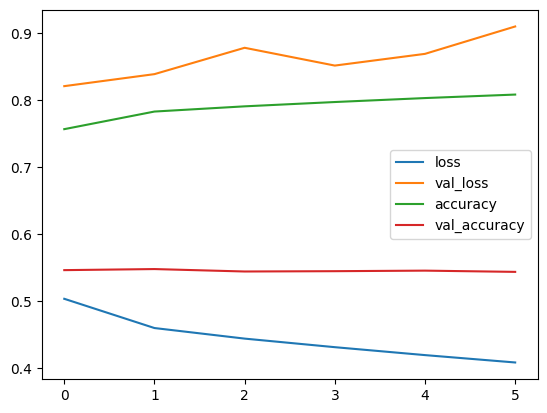

In [197]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label="loss")
plt.plot(h.history['val_loss'], label="val_loss")
plt.plot(h.history['accuracy'], label="accuracy")
plt.plot(h.history['val_accuracy'], label="val_accuracy")
plt.legend(loc='best')

# Transfert Learning - Utiliser d'autres Embeddings - Glove

On va essayer de garder notre preprocessing et de remplacer uniquement la couche d'embedding

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [202]:
!ls '/gdrive/MyDrive/pretrained-models'

glove.twitter.27B.50d.txt


In [4]:
glove_file_path = '/gdrive/MyDrive/pretrained-models/glove.twitter.27B.50d.txt'

In [6]:
import numpy as np

glove_embeddings = {}

with open(glove_file_path) as f:
  count = 0
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype="float32")

    glove_embeddings[word] = vector

In [211]:
len(glove_embeddings)

1193514

In [215]:
words = train_tokenizer.word_index.keys()

In [216]:
len(words)

204889

In [218]:
intersect = set(words).intersection(glove_embeddings.keys())
len(intersect)

78146

In [228]:
i = 0
for word in words:
  if glove_embeddings.get(word) is not None:
    i = i + 1
print(i)

78146


# Entrainement du modèle avec Glove Embedding

In [27]:
# On va définir l'embedding dimension & le vocab size en fonction du fichier de twitter:
# glove.twitter.27B.50d.txt => 50 dimensions
embedding_dimension = 50
vocab_size = len(glove_embeddings)

# Pour le moment, on crée une matrice avec les bonnes dimensions et uniquement des 0
embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in train_tokenizer.word_index.items():
  # Pour rechercher un élément dans un dictionnaire, qui peut ne pas exister, il faut utiliser le get pour ne pas provoquer d'erreur
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector


In [238]:
embedding_matrix[50]

array([ 1.32009998e-01,  6.97179973e-01,  2.30049998e-01, -5.42479992e-01,
       -6.26190007e-01, -5.15150011e-01,  1.80920005e+00,  5.62110007e-01,
        6.10939980e-01,  6.31219983e-01, -1.09430000e-01, -3.91669989e-01,
       -4.53830004e+00,  4.03530002e-01, -5.48200011e-01,  5.16830027e-01,
       -2.00220004e-01,  2.72480011e-01, -1.43729997e+00,  1.23379998e-01,
        6.32100031e-02,  1.48420006e-01,  1.61249995e-01,  4.47670013e-01,
        1.14749998e-01,  1.46219999e-01,  3.32340002e-01,  2.20029995e-01,
        5.83620012e-01, -6.39389992e-01,  2.72280008e-01,  4.84679997e-01,
       -9.45850015e-02,  3.83540004e-01,  1.90430000e-01,  1.81490004e-01,
       -7.04239979e-02, -2.85059988e-01,  1.04120001e-01,  7.14649975e-01,
       -7.90269971e-01,  2.83580005e-01,  7.71019995e-01,  6.32040024e-01,
        5.99579990e-01, -1.90430004e-02, -5.24640025e-04, -8.45500007e-02,
       -2.04229996e-01,  1.12810004e+00])

In [28]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Maintenant qu'on a alimenté la matrice avec le fichier dans la cellule ci-dessus
    # on peut fournir cette matrice de poids à la couche Embedding
    tf.keras.layers.Embedding(vocab_size, embedding_dimension, weights=embedding_matrix, trainable=False),
    # On remplace le RNN par LSTM wrappé dans un bidirectionnel
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    # LSTM sans bidirectionnelalité avec un dropout de 20%
    tf.keras.layers.LSTM(10, dropout=0.2),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(3, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
&
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
save_best_callback = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

In [1]:
h = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels),
              batch_size=1024,
              callbacks=[stop_callback, save_best_callback])

NameError: name 'model' is not defined